In [1]:
from pyscf import gto, dft, scf, lib, cc, fci
import numpy as np
import scipy as sp

In [138]:
from quchem.Hamiltonian.Hamiltonian_Generator_Functions import Hamiltonian_PySCF

H2O = Hamiltonian_PySCF('H2O')
H2O.Get_Geometry()
active_H2O = H2O.geometry

In [172]:
active_H2O[0]

('O', (0, 0, 0))

In [178]:
env_H2O[0]

('O', array([0. , 0. , 0.4]))

In [189]:
env_H2O=[]

for atom, coor in active_H2O:
    new_coor = -1*np.array(coor)+ np.array([0.2774, 0.8929, 1])
    env_H2O.append((atom,new_coor))
env_H2O

[('O', array([0.2774, 0.8929, 1.    ])),
 ('H', array([0.    , 0.    , 0.7456])),
 ('H', array([-0.3294,  1.1312,  1.7169]))]

<IPython.core.display.Javascript object>


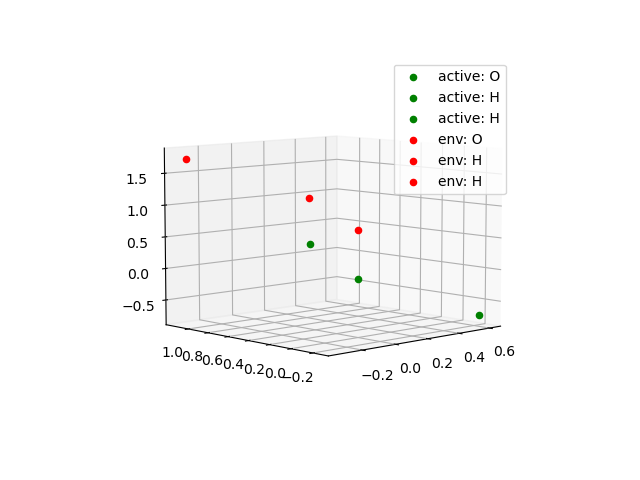

In [190]:
%matplotlib notebook

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

for ind, atom_coor in enumerate([*active_H2O, *env_H2O]):
    atom, coor = atom_coor
    if ind<len(active_H2O):
        ax.scatter(*coor, marker='o', color='green', label=f'active: {atom}')
    else:
        ax.scatter(*coor, marker='o', color='red', label=f'env: {atom}')
plt.legend()
plt.show()


In [191]:
basis_high_level='sto-3g'
basis_low_level='sto-3g'

low_level = 'b3lyp'#'lda,vwn'
high_level = 'UCCSD'

low_level_method='RSK'

low_level_reference = 'RSK' # DFT
high_level_reference = 'RHF' # for CC

In [192]:
high_level_system = gto.Mole(atom=active_H2O,
               basis=basis_high_level,
               charge=0,
               spin=0)

print(high_level_system.atom)
print('')
high_level_system.build()

[('O', (0, 0, 0)), ('H', (0.2774, 0.8929, 0.2544)), ('H', (0.6068, -0.2383, -0.7169))]



In [193]:
low_level_system = gto.Mole(atom=env_H2O,
               basis=basis_low_level,
               charge=0,
               spin=0)

print(low_level_system.atom)
print('')
low_level_system.build()

[('O', array([0.2774, 0.8929, 1.    ])), ('H', array([0.    , 0.    , 0.7456])), ('H', array([-0.3294,  1.1312,  1.7169]))]



In [194]:
full_system_mol = gto.mole.conc_mol(high_level_system, low_level_system)

In [195]:
n_active_atoms = high_level_system.aoslice_by_atom().shape[0]

In [196]:
low_level_full_sys = full_system_mol.copy()

if low_level_method.lower()=='rsk':
    scf_full_sys_low_levl = scf.RKS(low_level_full_sys)
    scf_full_sys_low_levl.kernel()
    
    v_xc_total = scf_full_sys_low_levl.get_veff()
    e_xc_total = v_xc_total.exc
else:
    raise ValueError(f'currently only RKS implemented not: {low_level_method}')
    
double_occ = (scf_full_sys_low_levl.mo_occ == 2).sum()
low_level_orbitals_occupied = scf_full_sys_low_levl.mo_coeff[:, :double_occ]

J_mat_low, K_mat_low = scf_full_sys_low_levl.get_jk()
V_xc_low_mat = v_xc_total - J_mat_low
h_core_low_mat = scf_full_sys_low_levl.get_hcore()

full_sys_ao_overlap = scf_full_sys_low_levl.get_ovlp()

converged SCF energy = -148.606263695853


In [197]:
### partition into subsystems!
import scipy as sp

n_active_aos = high_level_system.nao

s_half = sp.linalg.fractional_matrix_power(full_sys_ao_overlap, 0.5)

orthogonal_orbitals = np.dot(s_half, low_level_orbitals_occupied)[:n_active_aos, :]

u, s, v = np.linalg.svd(orthogonal_orbitals, full_matrices=True)
rotation_matrix = v
singular_values = s

In [198]:
full_system_mol.aoslice_by_atom().shape[0]

6

In [204]:
delta_singlue_vals = [-(singular_values[i+1] - singular_values[i]) for i in range(len(singular_values) - 1)] # diff of i and i+1


## argpartition(input_array, given_ind)
## only re-orders the input_array[given_ind] of the array!
## everything else kept the SAME
## smaller than input_array[given_ind] before the input_array[given_ind] val
## then everything after val
n_act_mos = np.argpartition(delta_singlue_vals, -1)[-1] + 1
# n_act_mos = np.where(delta_singlue_vals == np.max(delta_singlue_vals))[0][0]+1
n_env_mos = len(singular_values) - n_act_mos

In [205]:
# get active and env electron densities

act_orbitals = low_level_orbitals_occupied @ rotation_matrix.T[:, :n_act_mos]
env_orbitals = low_level_orbitals_occupied @ rotation_matrix.T[:, n_act_mos:]
act_density = 2.0 * act_orbitals @ act_orbitals.T
env_density = 2.0 * env_orbitals @ env_orbitals.T

In [206]:
J_env_low = scf_full_sys_low_levl.get_j(dm = env_density)
K_env_low = np.zeros_like(J_env_low) # k matrix contained in J_env_low!
two_elec_env_term_low= scf_full_sys_low_levl.get_veff(dm = env_density)
e_xc_env_low = two_elec_env_term_low.exc
v_xc_env_low = two_elec_env_term_low - J_env_low

Energy_env_low = np.trace(env_density.dot(h_core_low_mat + J_env_low/2)) + e_xc_env_low
Energy_env_low

-122.90555872272922

In [207]:
J_act_low = scf_full_sys_low_levl.get_j(dm = act_density)
K_act_low = np.zeros_like(J_act_low) # k matrix contained in J_env_low!
two_elec_act_term_low= scf_full_sys_low_levl.get_veff(dm = act_density)
e_xc_act_low = two_elec_act_term_low.exc
v_xc_act_low = two_elec_act_term_low - J_act_low

Energy_act_low = np.trace(env_density.dot(h_core_low_mat + J_act_low/2)) + e_xc_act_low
Energy_act_low

-152.42819226611795

In [208]:
# Computing cross subsystem terms
j_cross = 0.5 * (np.trace(act_density@J_env_low) + np.trace(env_density@J_act_low))
k_cross = np.zeros_like(j_cross)

xc_cross =e_xc_total - e_xc_act_low - e_xc_env_low # full_system - active - env

two_e_cross = j_cross + k_cross + xc_cross
print(two_e_cross)

37.534229827621786


In [209]:
# Defining the embedded core Hamiltonian

# mu = 1e6
# projector_level_shift = mu *  (full_sys_ao_overlap @ env_density @ full_sys_ao_overlap)
# print(projector_level_shift)

F_yammaB_S = scf_full_sys_low_levl.get_fock() @ env_density @ full_sys_ao_overlap 
projector_huzinaga = -1* (F_yammaB_S + F_yammaB_S.transpose())
print(projector_huzinaga)

[[ 1.18052521e-02  9.25980255e-02 -7.79274451e-03  4.16395572e-02
   1.21110244e-01  1.28896395e-01  6.61631398e-02  1.63802640e-04
   2.19613367e-01 -1.12856336e-01 -3.54113255e-01 -4.00374635e-02
   2.76344080e-01  4.43636085e-02]
 [ 9.25980255e-02  3.35890105e-01  8.01651487e-03  1.49551762e-01
   3.96844530e-01  6.74377029e-01  1.63891313e-01  8.44522205e-01
   9.59333261e-01 -2.54169313e-01 -6.43427336e-01 -3.33327026e-01
   7.96191988e-01  2.07148019e-01]
 [-7.79274451e-03  8.01651487e-03  1.41689260e-02 -6.32137657e-03
   2.77554319e-02  1.24011557e-01  1.90934298e-02  2.70471960e-01
   1.76734740e-01  1.63411644e-01 -8.47940339e-02 -1.11757795e-01
   6.64300979e-02 -8.90571786e-02]
 [ 4.16395572e-02  1.49551762e-01 -6.32137657e-03  6.20156540e-02
   1.96538291e-01  5.62318915e-01  7.62866783e-02  8.81873001e-01
   6.90794868e-01 -1.33114422e-01 -6.88426025e-02 -4.35384358e-01
   3.54789863e-01  8.70227192e-02]
 [ 1.21110244e-01  3.96844530e-01  2.77554319e-02  1.96538291e-01
  

In [210]:
# h_core_emb = h_core + embedding_potential + projector

v_emb = J_env_low + v_xc_total -v_xc_act_low +projector_huzinaga  # embedding_potential J_env + g_full - g_act + Projector

In [276]:
# run mean field HIGH LEVEL with embedded H

high_level_full_sys_HF_reference = full_system_mol.copy()
high_level_full_sys_HF_reference.nelectron= 2*n_act_mos

high_level_full_sys_HF_reference_SCF_EMBEDDED = scf.RHF(high_level_full_sys_HF_reference)
high_level_full_sys_HF_reference_SCF_EMBEDDED.get_hcore = lambda *args: v_emb + scf.hf.get_hcore(high_level_full_sys_HF_reference)# <-modified 
# high_level_full_sys_HF_reference_SCF_EMBEDDED.get_hcore = lambda *args:  -v_xc_act_low +projector_huzinaga + scf.hf.get_hcore(high_level_full_sys_HF_reference)# <-modified 
high_level_full_sys_HF_reference_SCF_EMBEDDED.kernel()


d_occ_high = (high_level_full_sys_HF_reference_SCF_EMBEDDED.mo_occ == 2).sum()
occupied_orbitals_high_ref = high_level_full_sys_HF_reference_SCF_EMBEDDED.mo_coeff[:, :d_occ_high]
J_mat_high_ref_EMBEDDED, K_mat_high_ref_EMBEDDED = high_level_full_sys_HF_reference_SCF_EMBEDDED.get_jk() 
v_xc_total_high_ref_EMBEDDED = high_level_full_sys_HF_reference_SCF_EMBEDDED.get_veff() - J_mat_high_ref_EMBEDDED
full_sys_ao_overlap_EMBEDDED = high_level_full_sys_HF_reference_SCF_EMBEDDED.get_ovlp()

converged SCF energy = 96.3810953942559


In [258]:
print(full_system_mol.nelectron)
print(high_level_full_sys_HF_reference.mol.nelectron)

20
converged SCF energy = -122.79439723992
10


In [259]:
density_emb = 2.0 * occupied_orbitals_high_ref @ occupied_orbitals_high_ref.T

In [260]:
Energy_act_emb = np.trace(np.dot(density_emb, h_core_low_mat + 0.5 * J_mat_high_ref_EMBEDDED - 0.25 * K_mat_high_ref_EMBEDDED))
Energy_act_emb

-134.924815816921

In [261]:
correction = np.trace(np.dot(v_emb, density_emb - act_density))
correction

32.472909461851195

In [262]:
Energy_mf_emb = Energy_act_low + Energy_env_low + two_e_cross +high_level_full_sys_HF_reference_SCF_EMBEDDED.energy_nuc() + correction

Energy_mf_emb

-145.65598777739018

In [263]:
# --- Post HF embedded calculation ---

## freeze projected orbitals!
total_nao = full_system_mol.nao
shift = total_nao - n_env_mos
frozen_orbitals = list(range(shift, total_nao))
# frozen_orbitals = list(range(n_act_mos,total_nao))

embedded_wf = cc.CCSD(high_level_full_sys_HF_reference_SCF_EMBEDDED).set(frozen = frozen_orbitals).run()

E(CCSD) = -63.98297051133521  E_corr = -0.1073621576220237


In [264]:
frozen_orbitals

[12, 13]

In [265]:
correlation_energy = embedded_wf.e_corr

In [266]:
e_total = Energy_mf_emb + correlation_energy
e_total

-145.7633499350122

In [267]:
full_system_mol.nao

14

In [268]:
myhf = scf.RHF(full_system_mol)
myhf.kernel()
cisolver = fci.FCI(full_system_mol, myhf.mo_coeff)
cisolver.kernel()

converged SCF energy = -148.962385543432


(-149.05507515840674,
 array([[-9.74701440e-01,  3.84494644e-02, -5.48763733e-15, ...,
          1.12728417e-21, -2.61987902e-09, -2.86598692e-10],
        [ 3.84494644e-02,  5.81599287e-02, -8.07039000e-15, ...,
          5.33690613e-21, -3.38883780e-10, -1.41034440e-09],
        [-5.48763733e-15, -8.07039000e-15,  1.50902918e-02, ...,
          4.95535156e-09,  6.85874898e-22,  2.70454929e-22],
        ...,
        [ 1.12728417e-21,  5.33690613e-21,  4.95535156e-09, ...,
         -3.38063188e-10, -1.99863101e-24,  1.33285577e-24],
        [-2.61987902e-09, -3.38883780e-10,  6.85874898e-22, ...,
         -1.99863101e-24, -2.17590533e-10, -4.95690075e-11],
        [-2.86598692e-10, -1.41034440e-09,  2.70454929e-22, ...,
          1.33285577e-24, -4.95690075e-11, -2.43489576e-09]]))

In [269]:
print('low level:', scf_full_sys_low_levl.e_tot)

print('WF_in_DFT =', e_total)

print('FCI =', cisolver.e_tot)

low level: -148.6062636958525
WF_in_DFT = -145.7633499350122
FCI = -149.05507515840674


In [270]:
from openfermionpyscf._run_pyscf import compute_integrals

one_electron_integrals, two_electron_integrals = compute_integrals(high_level_full_sys_HF_reference, 
                                                                   high_level_full_sys_HF_reference_SCF_EMBEDDED)

In [271]:
import openfermion.ops.representations as reps
active_orbitals = list(range(shift))

occupied_indices = np.where(high_level_full_sys_HF_reference_SCF_EMBEDDED.mo_occ==2)[0]

core_adjustment, one_body_integrals, two_body_integrals = reps.get_active_space_integrals(
                                            one_electron_integrals,
                                               two_electron_integrals,
                                               occupied_indices, active_orbitals)

constant = high_level_full_sys_HF_reference_SCF_EMBEDDED.energy_nuc() + core_adjustment

In [274]:
from openfermion.chem.molecular_data import spinorb_from_spatial

one_body_coefficients, two_body_coefficients = spinorb_from_spatial(
            one_body_integrals, two_body_integrals)

molecular_hamiltonian = reps.InteractionOperator(
            constant, one_body_coefficients, 1 / 2 * two_body_coefficients)

In [275]:
from openfermion import get_sparse_operator

H = get_sparse_operator(molecular_hamiltonian)

KeyboardInterrupt: 

In [ ]:
val, vec = sp.linalg.eig(H.todense())
min(val)

In [35]:
### partition into subsystems!

n_active_aos = high_level_system.nao

s_half = sp.linalg.fractional_matrix_power(full_sys_ao_overlap_EMBEDDED, 0.5)

orthogonal_orbitals = np.dot(s_half, occupied_orbitals_high_ref)[:n_active_aos, :]

u, s, v = np.linalg.svd(orthogonal_orbitals, full_matrices=True)
rotation_matrix = v
singular_values = s

In [36]:
delta_singlue_vals = [-(singular_values[i+1] - singular_values[i]) for i in range(len(singular_values) - 1)] # diff of i and i+1


## argpartition(input_array, given_ind)
## only re-orders the input_array[given_ind] of the array!
## everything else kept the SAME
## smaller than input_array[given_ind] before the input_array[given_ind] val
## then everything after val
# n_act_mos = np.argpartition(delta_singlue_vals, -1)[-1] + 1
n_act_mos = np.where(delta_singlue_vals == np.max(delta_singlue_vals))[0][0]+1
n_env_mos = len(singular_values) - n_act_mos

ValueError: zero-size array to reduction operation maximum which has no identity

In [ ]:
# argparition only sorts array 
n_act_mos = np.argpartition(delta_s, -1)[-1] + 1 
n_env_mos = len(singular_values) - n_act_mos
n_env_mos

In [ ]:
full_system_mol.aoslice_by_atom()[high_level_system.nao-1][3] # 3rd index gives end AO ID

In [ ]:
high_level_system.nao

define full system

In [40]:
full_system = gto.mole.conc_mol(high_level_system, low_level_system)

list_of_subsystems = [high_level_system, low_level_system]

nao = np.array([subsystem.mol.nao_nr() for subsystem in list_of_subsystems])
nssl = [None for i in range(len(list_of_subsystems))]

for i, sub in enumerate(list_of_subsystems):
    nssl[i] = np.zeros(sub.mol.natm, dtype=int)
    for j in range(sub.mol.natm):
        ib_t = np.where(sub.mol._bas.transpose()[0] == j)[0]
        i_b = ib_t.min()
        ie_t = np.where(sub.mol._bas.transpose()[0] == j)[0]
        i_e = ie_t.max()
        i_r = sub.mol.nao_nr_range(i_b, i_e + 1)
        i_r = i_r[1] - i_r[0]
        nssl[i][j] = i_r

    assert nssl[i].sum() == sub.mol.nao_nr(), "naos not equal!"

nsl = np.zeros(full_system.natm, dtype=int) #<-- full system here
for i in range(full_system.mol.natm):
    i_b = np.where(full_system.mol._bas.transpose()[0] == i)[0].min()
    i_e = np.where(full_system.mol._bas.transpose()[0] == i)[0].max()
    i_r = full_system.mol.nao_nr_range(i_b, i_e + 1)
    i_r = i_r[1] - i_r[0]
    nsl[i] = i_r

assert nsl.sum() == full_system.mol.nao_nr(), "naos not equal!"

sub2sup = [None for i in range(len(list_of_subsystems))]
for i, sub in enumerate(list_of_subsystems):
    sub2sup[i] = np.zeros(nao[i], dtype=int)
    for j in range(sub.mol.natm):
        match = False
        c_1 = sub.mol.atom_coord(j)
        for k in range(full_system.mol.natm):
            c_2 = full_system.mol.atom_coord(k)
            dist = np.dot(c_1 - c_2, c_1 - c_2)
            if dist < 0.0001:
                match = True
                i_a = nssl[i][0:j].sum()
                j_a = i_a + nssl[i][j]
                # ja = ia + nsl[b]
                i_b = nsl[0:k].sum()
                j_b = i_b + nsl[k]
                # jb = ib + nssl[i][a]
                sub2sup[i][i_a:j_a] = range(i_b, j_b)

        assert match, 'no atom match!'

sub2sup

converged SCF energy = -1.11675930739642
converged SCF energy = -1.11675930739643
converged SCF energy = -1.11675930739642
converged SCF energy = -1.11675930739642
converged SCF energy = -1.11675930739642
converged SCF energy = -1.11675930739642
converged SCF energy = -1.11675930739642
converged SCF energy = -1.11675930739642
converged SCF energy = -1.11675930739642
converged SCF energy = -1.11675930739642
converged SCF energy = -1.11675930739642
converged SCF energy = -1.11675930739643
converged SCF energy = -1.11675930739643
converged SCF energy = -1.11675930739643
converged SCF energy = -1.11675930739643
converged SCF energy = -1.11675930739643
converged SCF energy = -1.11675930739643
converged SCF energy = -1.11675930739643
converged SCF energy = -1.11675930739643
converged SCF energy = -1.11675930739643
converged SCF energy = -2.2317175887261
converged SCF energy = -2.2317175887261
converged SCF energy = -2.2317175887261
converged SCF energy = -2.2317175887261
converged SCF energy

[array([0, 1]), array([2, 3])]

In [ ]:
## scf subsystem A
scf_system_A = scf.RKS(mol_A)
scf_system_A.xc = 'lda,vwn'
scf_system_A.kernel()
## occupied orbitals!
double_occ_subA = (scf_system_A.mo_occ == 2).sum()
occupied_orbitals_subsys_A = scf_system_A.mo_coeff[:, :double_occ_subA]
occupied_orbitals_subsys_A

In [ ]:
projected_mol_A = mol_A.copy()
projected_mol_A_ao_overlap = projected_mol_A.intor_symmetric('int1e_ovlp_sph')#[:, :double_occ]

overlap_two_basis = gto.intor_cross('int1e_ovlp_sph', full_system, projected_mol_A)#[:double_occ, :]
# overlap_two_basis_sub_A = overlap_two_basis[np.ix_(sub2sup[0], sub2sup[0])]  # select subsystem A
overlap_two_basis_sub_A = overlap_two_basis[:mol_A.nao]  # select subsystem B

projected_orbitals_subsystemA = (np.linalg.inv(projected_mol_A_ao_overlap) @ overlap_two_basis_sub_A @ occupied_orbitals_subsys_A)
projected_orbitals_subsystemA

In [ ]:
occupied_orbitals_subsys_A

In [ ]:
overlap_two_basis_sub_A

In [ ]:
overlap_two_basis[2:]

In [ ]:
overlap_two_basis[double_occ_subB+1:]

In [ ]:
## scf subsystem A
scf_system_B = scf.RKS(mol_B)
scf_system_B.xc = 'lda,vwn'
scf_system_B.kernel()
## occupied orbitals!
double_occ_subB = (scf_system_B.mo_occ == 2).sum()
occupied_orbitals_subsys_B = scf_system_B.mo_coeff[:, :double_occ_subB]
print(occupied_orbitals_subsys_B)

projected_mol_B = mol_B.copy()
projected_mol_B_ao_overlap = projected_mol_B.intor_symmetric('int1e_ovlp_sph')

overlap_two_basis = gto.intor_cross('int1e_ovlp_sph', full_system, projected_mol_B)#[:double_occ_subB, :]
overlap_two_basis_sub_B = overlap_two_basis[mol_A.nao:]  # select subsystem B (aka ignore sysA defined first)

projected_orbitals_subsystemB = (np.linalg.inv(projected_mol_B_ao_overlap) @ overlap_two_basis_sub_B @ occupied_orbitals_subsys_B)
projected_orbitals_subsystemB

In [ ]:
## scf
full_system_scf = scf.RKS(full_system)
full_system_scf.xc = 'lda,vwn'
full_system_scf.kernel()

## occupied orbitals!
double_occ = (full_system_scf.mo_occ == 2).sum()
occupied_orbitals = full_system_scf.mo_coeff[:, :double_occ]

In [ ]:
full_system_ao_overlap = full_system.intor_symmetric('int1e_ovlp') # better than get_ovlp

s_half = scipy.linalg.fractional_matrix_power(ao_overlap, 0.5)
orthogonal_orbitals = (s_half @ orbitals)[:n_active_aos, :]

rotation_matrix, sigma = embed.orbital_rotation(projection_orbitals,
        n_act_aos, ao_overlap)

In [ ]:
full_system.aoslice_by_atom()
full_system.aoslice_by_atom()[mol_A.nao-1][3] # 3rd index gives end AO ID
full_system.aoslice_by_atom()[mol_A.nao][2] # 2nd index gives start AO ID

In [ ]:
overlap_two_basis

In [ ]:

projected_mol = full_system.copy()

full_system_ao_overlap = full_system.intor_symmetric('int1e_ovlp_sph') # better than get_ovlp

projected_overlap = full_system_ao_overlap#[:, :double_occ]
overlap_two_basis = gto.intor_cross('int1e_ovlp_sph', full_system, projected_mol)#[:double_occ, :]


projected_orbitals = (np.linalg.inv(projected_overlap) @ overlap_two_basis @ occupied_orbitals)
projected_orbitals

In [ ]:
full_system = gto.mole.conc_mol(scf_system_A.mol, scf_system_B.mol)
ao_overlap = full_system.intor_symmetric('int1e_ovlp') # better than get_ovlp

s_half = scipy.linalg.fractional_matrix_power(ao_overlap, 0.5)
        orthogonal_orbitals = (s_half @ orbitals)[:n_active_aos, :]

    u, s, v = np.linalg.svd(orthogonal_orbitals, full_matrices=True)
    rotation_matrix = v
    singular_values = s

In [ ]:
 scf_system_A.get_hcore()

np.zeros((scf_system_A.mol.nao_nr(), scf_system_A.mol.nao_nr()), dtype=float)

# Freeze and thaw

In [ ]:
list_of_subsystems = [scf_system_A, scf_system_B]

freeze_thaw_error = 1 # needed for start of loop (overwritten)
freeze_thaw_iter = 0
    while (freeze_thaw_error>self.freeze_thaw_conv) and (freeze_thaw_iter < self.freeze_thaw_max_iter):
        
        
    for active_index, active_subsystem in enumerate(list_of_subsystems):
        
        for env_index, env_subsystem in enumerate(list_of_subsystems):
            if active_index == env_index:
                continue
            else:
                SubSys_projection_OP = np.zeros_like(active_subsystem.hcore)

In [ ]:
full_system.atom


In [ ]:
full_system.aoslice_nr_by_atom()[3]

In [ ]:
full_system = gto.mole.conc_mol(scf_system_A.mol, scf_system_B.mol)